#Genetic Algorithm Based Evolution of Hippocampal Memory Models with Hopfield Networks

#Creating the Hopfield Network

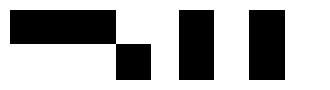

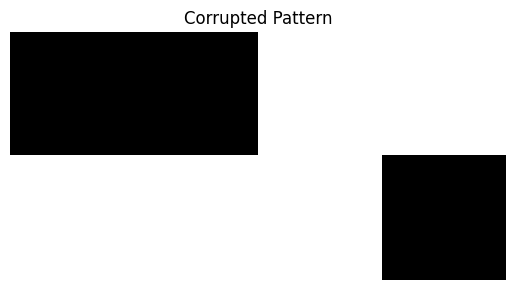

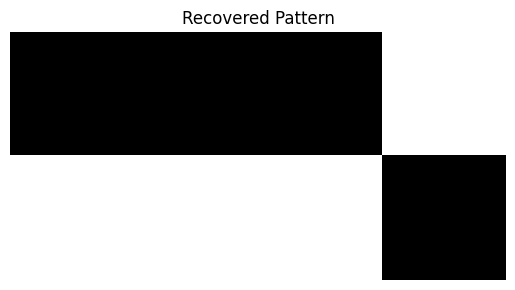

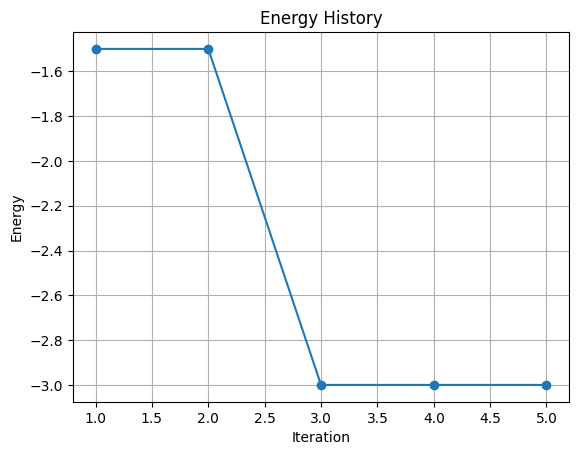

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class HopfieldNetwork:
    def __init__(self, n):
        self.n = n
        self.weights = np.zeros((n, n))

    def train(self, patterns):
        for pattern in patterns:
            pattern = np.array(pattern).reshape(-1, 1)
            self.weights += np.dot(pattern, pattern.T)
            np.fill_diagonal(self.weights, 0)
        self.weights /= self.n

    def energy(self, state):
        return -0.5 * np.dot(np.dot(state.T, self.weights), state)

    def update_async(self, state, steps=100):
        energy_history = []
        for _ in range(steps):
            i = np.random.randint(self.n)
            activation = np.dot(self.weights[i], state)
            state[i] = np.sign(activation)
            energy = self.energy(state)
            energy_history.append(energy)
        return state, energy_history

def plot_patterns(patterns, nrows, ncols):
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*2, nrows*2))
    for i, ax in enumerate(axes.flat):
        ax.imshow(np.array(patterns[i]).reshape(int(np.sqrt(len(patterns[i]))), -1), cmap='binary')
        ax.axis('off')
    plt.show()

def simulate_hopfield(patterns, corrupted_pattern, noise_level=0.1, max_iters=5):
    n = len(patterns[0])
    network = HopfieldNetwork(n)
    network.train(patterns)

    # Corrupt the pattern with noise
    corrupted_pattern = np.array(corrupted_pattern)
    corrupted_pattern[corrupted_pattern == 0] = -1
    corrupted_pattern = np.sign(corrupted_pattern + noise_level * np.random.randn(*corrupted_pattern.shape))

    # Plot original patterns
    plot_patterns(patterns, 1, len(patterns))

    # Plot corrupted pattern
    plt.imshow(corrupted_pattern.reshape(int(np.sqrt(n)), -1), cmap='binary')
    plt.title('Corrupted Pattern')
    plt.axis('off')
    plt.show()

    # Simulate network dynamics to recover the pattern
    recovered_pattern, energy_history = network.update_async(corrupted_pattern, steps=max_iters)

    # Plot the recovered pattern
    plt.imshow(recovered_pattern.reshape(int(np.sqrt(n)), -1), cmap='binary')
    plt.title('Recovered Pattern')
    plt.axis('off')
    plt.show()

    # Plot the energy history
    plt.plot(range(1, max_iters + 1), energy_history, marker='o')
    plt.title('Energy History')
    plt.xlabel('Iteration')
    plt.ylabel('Energy')
    plt.grid(True)
    plt.show()

# Example usage
if __name__ == "__main__":
    # Define patterns for training
    patterns = [
        [1, 1, 1, -1, -1, -1, -1, 1],
        [1, -1, 1, -1, 1, -1, 1, -1]
    ]

    # Define a corrupted pattern for retrieval
    corrupted_pattern = [1, 1, -1, -1, -1, -1, -1, 1]

    # Simulate Hopfield network to retrieve the corrupted pattern
    simulate_hopfield(patterns, corrupted_pattern, noise_level=0.4, max_iters=5)


#Genetic Algorithm for the Hopfield Network that we created above

In [ ]:
class HopfieldNetwork:    #create a HOpfield Network class
    def __init__(self, n):
        self.n = n
        self.weights = np.zeros((n, n))

    def energy(self, state):
        return -0.5 * np.dot(np.dot(state.T, self.weights), state)

    def update_async(self, state, steps=100):
        for _ in range(steps):
            i = np.random.randint(self.n)
            activation = np.dot(self.weights[i], state)
            state[i] = np.sign(activation)
        return state

class HopfieldGA:    #create a class called HopfieldGA
    def __init__(self, n, population_size, mutation_rate):
        self.n = n
        self.population_size = population_size
        self.mutation_rate = mutation_rate
        self.population = np.random.choice([-1, 1], size=(population_size, n*n))
        self.best_solution = None
        self.best_fitness = float('-inf')
        self.fitness_history = []  # Initialise fitness history
        self.diversity_history = []  # Initialise diversity history

    def sensitivity_analysis(self, patterns, max_generations, crossover_rates, mutation_rates):
        results = []
        for cr in crossover_rates:
            for mr in mutation_rates:
                self.crossover_rate = cr
                self.mutation_rate = mr
                self.population = np.random.choice([-1, 1], size=(self.population_size, self.n*self.n))
                self.best_solution = None
                self.best_fitness = float('-inf')
                self.fitness_history = []  # Reset fitness history
                self.diversity_history = []  # Reset diversity history

                self.train(patterns, max_generations)

                results.append({
                    'crossover_rate': cr,
                    'mutation_rate': mr,
                    'best_fitness': self.best_fitness,
                    'fitness_history': self.fitness_history,
                    'diversity_history': self.diversity_history
                })

        return results

    def calculate_diversity(self):
        diversity = 0
        for i in range(self.population_size):
            for j in range(i + 1, self.population_size):
                diversity += np.sum(self.population[i] != self.population[j])
        return diversity / ((self.population_size * (self.population_size - 1)) / 2)

    def calculate_hamming_distance(self, individual1, individual2):
        return np.sum(individual1 != individual2)

    def calculate_population_diversity(self, population):
        diversity = []
        for i in range(len(population)):
            for j in range(i + 1, len(population)):
                diversity.append(self.calculate_hamming_distance(population[i], population[j]))
        return np.mean(diversity)

    def train(self, patterns, max_generations):
        for generation in range(max_generations):
            fitness_values = self.calculate_fitness(patterns)
            self.update_best_solution(fitness_values)
            self.fitness_history.append(max(fitness_values))  # Record fitness history
            self.diversity_history.append(self.calculate_diversity())  # Record diversity history

            if self.best_fitness == 0:  # If found a perfect solution
                break

            self.selection(fitness_values)
            self.crossover()
            self.mutation()

    def calculate_fitness(self, patterns):
        fitness_values = []
        for individual in self.population:
            weights = individual.reshape(self.n, self.n)
            network = HopfieldNetwork(self.n)
            network.weights = weights
            energy = sum(network.energy(np.array(pattern).reshape(-1, 1)) for pattern in patterns)
            fitness_values.append(-energy)  # Negative energy as we want to minimize it
        return fitness_values

    def update_best_solution(self, fitness_values):
        max_fitness_index = np.argmax(fitness_values)
        if fitness_values[max_fitness_index] > self.best_fitness:
            self.best_fitness = fitness_values[max_fitness_index]
            self.best_solution = self.population[max_fitness_index]

    def selection(self, fitness_values):
        total_fitness = sum(fitness_values)
        if total_fitness == 0:
            # If total fitness is 0, assign equal probabilities to all individuals
            selection_probabilities = np.full(self.population_size, 1/self.population_size)
        else:
            min_fitness = min(fitness_values)
            shifted_fitness_values = [fitness - min_fitness for fitness in fitness_values]

            # Ensure that shifted fitness values are non-negative
            shifted_fitness_values = [max(0, fitness) for fitness in shifted_fitness_values]

            # Calculate selection probabilities
            total_non_negative_fitness = sum(shifted_fitness_values)

            if total_non_negative_fitness == 0:
                # If total non-negative fitness is 0, assign equal probabilities to all individuals
                selection_probabilities = np.full(self.population_size, 1/self.population_size)
            else:
                selection_probabilities = np.array([fitness / total_non_negative_fitness for fitness in shifted_fitness_values])

        # Flatten the 2D array to 1D
        selection_probabilities = selection_probabilities.flatten()

        selected_indices = np.random.choice(
            range(self.population_size),
            size=self.population_size,
            p=selection_probabilities
        )
        self.population = self.population[selected_indices]

    def crossover(self):
        # Perform one-point crossover between selected individuals
        for i in range(0, self.population_size, 2):
            parent1 = self.population[i]
            parent2 = self.population[i + 1]

            crossover_point = np.random.randint(1, self.n*self.n - 1)  # Choose crossover point
            child1 = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
            child2 = np.concatenate((parent2[:crossover_point], parent1[crossover_point:]))

            self.population[i] = child1
            self.population[i + 1] = child2

    def mutation(self):
        # Perform bit-flip mutation on the population
        for i in range(self.population_size):
            if np.random.rand() < self.mutation_rate:
                mutation_point = np.random.randint(0, self.n*self.n)
                self.population[i][mutation_point] *= -1  # Flip the bit

if __name__ == "__main__":
    # Define patterns for training
    patterns = [
        [1, 1, 1, -1, -1, -1, -1, 1],
        [1, -1, 1, -1, 1, -1, 1, -1]
    ]

    # Hyperparameters
    n = len(patterns[0])
    population_size = 50
    mutation_rate = 0.1
    max_generations = 100

    # Train Hopfield Network using Genetic Algorithm
    hopfield_ga = HopfieldGA(n, population_size, mutation_rate)
    hopfield_ga.train(patterns, max_generations)

    # Retrieve the best solution
    best_weights = hopfield_ga.best_solution.reshape(n, n)
    print("Best Solution (Weights):\n", best_weights)

Best Solution (Weights):
 [[ 1  1  1 -1  1 -1  1  1]
 [-1  1 -1 -1 -1 -1 -1  1]
 [ 1  1  1 -1 -1 -1 -1  1]
 [-1 -1 -1  1  1  1  1  1]
 [ 1 -1  1  1  1 -1  1 -1]
 [-1  1 -1  1  1  1  1  1]
 [ 1 -1 -1 -1  1  1  1 -1]
 [-1  1 -1  1 -1  1 -1  1]]


#Convergence Analysis

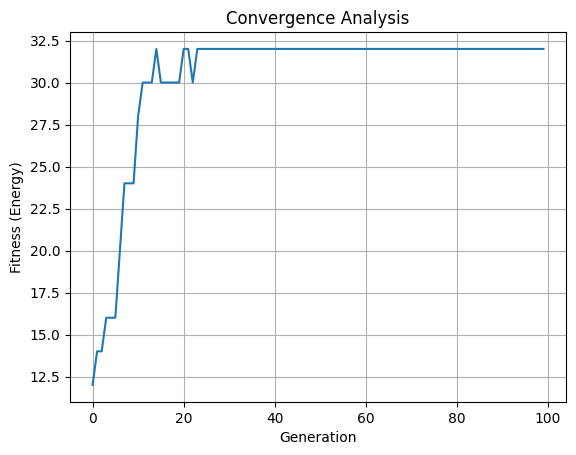

In [ ]:
# Convergence Analysis
plt.plot(range(len(hopfield_ga.fitness_history)), np.squeeze(hopfield_ga.fitness_history))
plt.title('Convergence Analysis')
plt.xlabel('Generation')
plt.ylabel('Fitness (Energy)')
plt.grid(True)
plt.show()

#Diversity Analysis

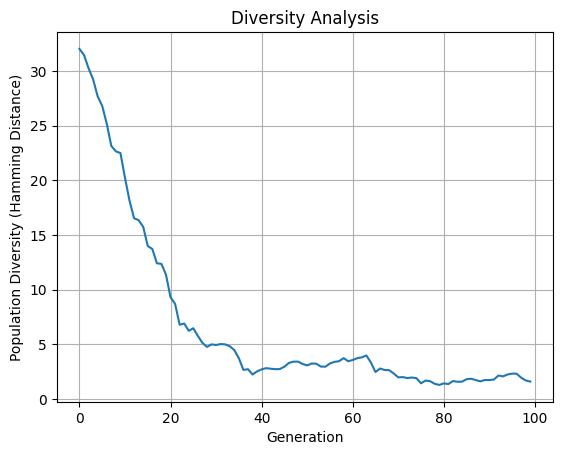

In [ ]:
# Plot Diversity Analysis
plt.plot(range(max_generations), np.squeeze(hopfield_ga.diversity_history))
plt.title('Diversity Analysis')
plt.xlabel('Generation')
plt.ylabel('Population Diversity (Hamming Distance)')
plt.grid(True)
plt.show()

#Sensitivity Analysis

Crossover Rates: [0.5 0.5 0.5 0.7 0.7 0.7 0.9 0.9 0.9]
Mutation Rates: [0.01 0.05 0.1  0.01 0.05 0.1  0.01 0.05 0.1 ]
Best Fitnesses: [[[32.]]

 [[32.]]

 [[32.]]

 [[30.]]

 [[32.]]

 [[32.]]

 [[30.]]

 [[32.]]

 [[32.]]]


<ipython-input-41-a5058cc7523f>:22: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(crossover_rates, mutation_rates, best_fitnesses, cmap='viridis')


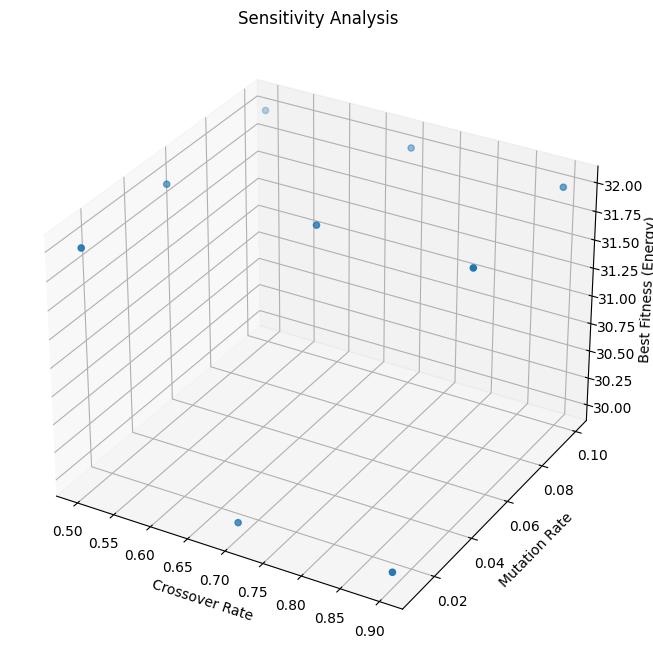

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
# Define crossover and mutation rates to test
crossover_rates = [0.5, 0.7, 0.9]
mutation_rates = [0.01, 0.05, 0.1]

# Perform sensitivity analysis
results = hopfield_ga.sensitivity_analysis(patterns, max_generations, crossover_rates, mutation_rates)

# Extract data for plotting
crossover_rates = np.array([result['crossover_rate'] for result in results])
mutation_rates = np.array([result['mutation_rate'] for result in results])
best_fitnesses = np.array([result['best_fitness'] for result in results])

# Print extracted data for debugging
print("Crossover Rates:", crossover_rates)
print("Mutation Rates:", mutation_rates)
print("Best Fitnesses:", best_fitnesses)

# Plot the sensitivity analysis graph
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(crossover_rates, mutation_rates, best_fitnesses, cmap='viridis')
ax.set_xlabel('Crossover Rate')
ax.set_ylabel('Mutation Rate')
ax.set_zlabel('Best Fitness (Energy)')
ax.set_title('Sensitivity Analysis')
plt.show()


The output above represents the best solution found by the genetic algorithm for the Hopfield network weights. Each row in the matrix represents one neuron in the network, and each column represents the connection weights from one neuron to all other neurons.

For example, the element at position (0, 0) represents the weight of the connection from neuron 0 to itself. The element at position (0, 1) represents the weight of the connection from neuron 0 to neuron 1, and so on.

In the context of the Hopfield network, these connection weights are learned during training to store the given patterns in memory and retrieve them later. The specific values of these weights determine how well the network can recall the patterns it was trained on.

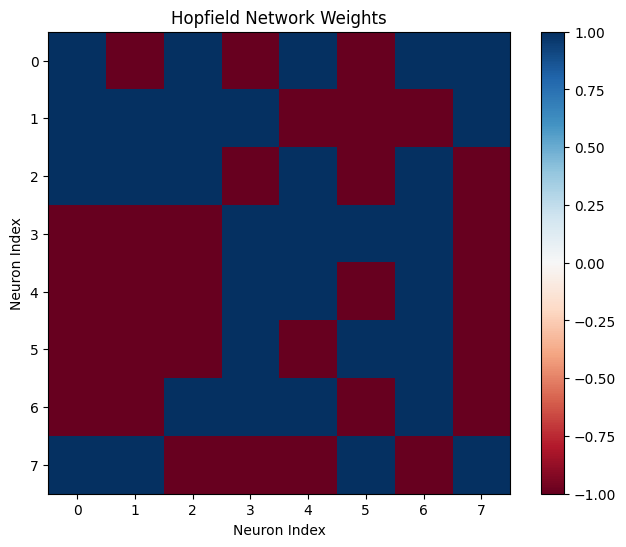

In [ ]:
'''Creating a Heatmap - The colors indicate the strength of the connection, with blue representing negative weights,
red representing positive weights,& white representing zero weights.'''

import numpy as np
import matplotlib.pyplot as plt

def visualize_hopfield_network(weights):
    plt.figure(figsize=(8, 6))
    plt.imshow(weights, cmap='RdBu', vmin=-1, vmax=1)
    plt.colorbar()
    plt.title('Hopfield Network Weights')
    plt.xlabel('Neuron Index')
    plt.ylabel('Neuron Index')
    plt.show()

# Define the best solution (weights) obtained from the genetic algorithm
best_weights = np.array([
    [1, -1, 1, -1, 1, -1, 1, 1],
    [1, 1, 1, 1, -1, -1, -1, 1],
    [1, 1, 1, -1, 1, -1, 1, -1],
    [-1, -1, -1, 1, 1, 1, 1, -1],
    [-1, -1, -1, 1, 1, -1, 1, -1],
    [-1, -1, -1, 1, -1, 1, 1, -1],
    [-1, -1, 1, 1, 1, -1, 1, -1],
    [1, 1, -1, -1, -1, 1, -1, 1]
])

# Visualize the Hopfield network
visualize_hopfield_network(best_weights)

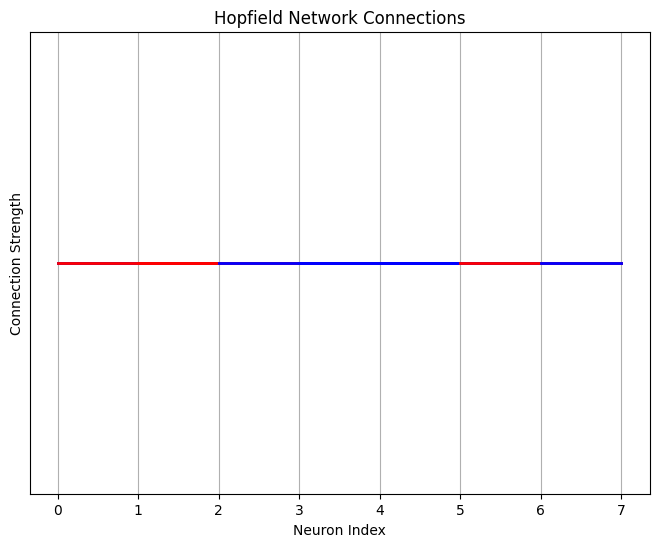

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_hopfield_connections(weights):
    plt.figure(figsize=(8, 6))
    n = len(weights)
    for i in range(n):
        for j in range(n):
            if i != j:
                weight = weights[i, j]
                if weight > 0:
                    plt.plot([i, j], [0.1, 0.1], color='red', alpha=weight, linewidth=2)
                elif weight < 0:
                    plt.plot([i, j], [0.1, 0.1], color='blue', alpha=-weight, linewidth=2)

    plt.title('Hopfield Network Connections')
    plt.xlabel('Neuron Index')
    plt.ylabel('Connection Strength')
    plt.xticks(range(n))
    plt.yticks([])
    plt.grid(axis='x')
    plt.show()

# Define the best solution (weights) obtained from the genetic algorithm
best_weights = np.array([
    [1, -1, 1, -1, 1, -1, 1, 1],
    [1, 1, 1, 1, -1, -1, -1, 1],
    [1, 1, 1, -1, 1, -1, 1, -1],
    [-1, -1, -1, 1, 1, 1, 1, -1],
    [-1, -1, -1, 1, 1, -1, 1, -1],
    [-1, -1, -1, 1, -1, 1, 1, -1],
    [-1, -1, 1, 1, 1, -1, 1, -1],
    [1, 1, -1, -1, -1, 1, -1, 1]
])

# Visualize the Hopfield network connections
visualize_hopfield_connections(best_weights)

##Visualising the neural network using networkx

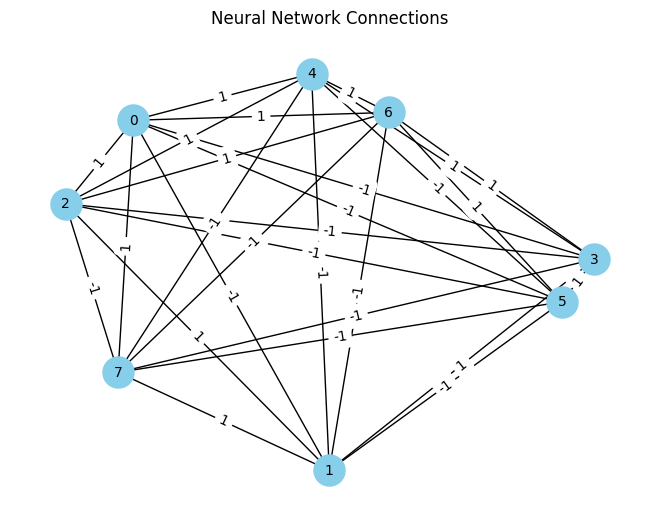

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

def visualize_network(weights):
    n = len(weights)

    # Create a graph
    G = nx.Graph()

    # Add nodes (neurons)
    for i in range(n):
        G.add_node(i)

    # Add edges (connections)
    for i in range(n):
        for j in range(i+1, n):
            if weights[i, j] != 0:
                G.add_edge(i, j, weight=weights[i, j])

    # Draw the graph
    pos = nx.spring_layout(G)  # Positions of nodes
    edge_labels = {(i, j): round(d['weight'], 2) for i, j, d in G.edges(data=True)}
    nx.draw(G, pos, with_labels=True, node_size=500, node_color='skyblue', font_size=10)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    plt.title('Neural Network Connections')
    plt.show()

# Best Solution (Weights) obtained from genetic algorithm
best_weights = np.array([
    [1, -1, 1, -1, 1, -1, 1, 1],
    [1, 1, 1, 1, -1, -1, -1, 1],
    [1, 1, 1, -1, 1, -1, 1, -1],
    [-1, -1, -1, 1, 1, 1, 1, -1],
    [-1, -1, -1, 1, 1, -1, 1, -1],
    [-1, -1, -1, 1, -1, 1, 1, -1],
    [-1, -1, 1, 1, 1, -1, 1, -1],
    [1, 1, -1, -1, -1, 1, -1, 1]
])

# Visualize the neural network
visualize_network(best_weights)